In [1]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as pl
from matplotlib import rcParams
from matplotlib import rc
import pandas
from time import time
import shutil
import glob
# THIS LAST BIT IS TO NAVIAGATE TO WHERE MY CUSTOM MODULES ARE LOCATED
import os
if os.getcwd()[-14:] != 'AIMS':
    default_path = os.getcwd()[:-10]
    os.chdir(default_path)
import aims_loader as aimsLoad
import aims_analysis as aims

# Here is the Notebook Version of the AIMS GUI
Mostly identical to what is going on inside the app, but you have a little bit more flexibility for customization. 

# We now have some sorted data based upon haplotype
Let's start with a 53 year old male "A24_A29_B07_B52"
Has NAIVE and TEM subsets from all possible sources
Start comparing just ALL NAIVE and ALL TEM from this patient

# Some Notes from Dr. Farber's Science Paper
So it seems like the lab DOES find some clonal differences, I would like to recapitulate those in some way

Finding 1: TCR repertoire diversity of naïve T cells decreases with age and is distinct from TEM subsets. PRONOUNCED IN CD8. Their age cutoff is 40.
So perhaps in younger patients, we may find more significant differences between Naive/TEM/certain tissues
They do only look at 3beta in the paper

Finding 2: They do NOT find differences in DIVERSITY across lymphoid tissues within a given patient
This is important, suggests I shouldn't spend too much time looking at this. HOWEVAH (Stephen A Smith voice) this doesn't mean that there aren't clonal differences in tissue. These are all of the same tissue type (lymphoid).

Finding 3: "We assessed sequence overlap among the top 1000 clones for naïve and TEM cells from each of three tissues within individuals of different ages... As previously reported (7), and consistent with additional donors from all ages whom we examined, there was an appreciable overlap in TEM clones between sites, with 20 to 30% of CD4 TEM clones and >40% of CD8 TEM clones found in more than one tissue site. By contrast, there were remarkably few naïve T cell clones found in more than one site, with the vast majority of naïve T cell clones unique to [the tissue]"
This analysis is one that I need to do. Actual comparison of strings to look at clonal overlap. Try to do this one beat for beat.

Finding 4: EVIDENTLY, there are differences between Naive Spleen and LLN repertoires in older individuals (look SPECIFICALLY at a 51 y/o compared to a 21 y/o).
So I REALLY should be able to see this with the entropy. Try to code in the left/right alignment and see if we can recapitulate this.

Notes: Remember, CD45RA+ and CCR7+ is the NAIVE phenotype. LLN = Brachial Lymph Node

In [3]:
# So these data are ONLY Beta chain, which is a bit of a bummer.
num_loop=1
label = ['Inguinal','Brachial']
tissue_dir = '/Users/boughterct/Desktop/rnaSeq/Adaptive/CD8_parse/'
Haplo = 'A24_A29_B07_B52/'
sub1 = 'TEM/'+Haplo
sub2 = 'TEM/'+Haplo

# Let's loop through all things that match some sort of specifity
first = True
# IF you want ALL organs, leave it at "*csv"
wild1 = '*Inguinal*csv'
wild2 = '*Brachial*csv'
for i in glob.glob(tissue_dir+sub1+wild1):
    if first:
        d1 = pandas.read_csv(i,sep=',')['amino_acid']
        first = False
    else:
        pred =  pandas.read_csv(i,sep=',')['amino_acid']
        d1 = pandas.concat([d1,pred])
first = True
for i in glob.glob(tissue_dir+sub2+wild2):
    if first:
        d2 = pandas.read_csv(i,sep=',')['amino_acid']
        first = False
    else:
        pred =  pandas.read_csv(i,sep=',')['amino_acid']
        d2 = pandas.concat([d2,pred])

# need to make a header automatically for EVERY sequence.
# should probably try ot make it out of the metadata
num1 = np.shape(d1)[0]
for i in np.arange(num1):
    if i ==0:
        tab1 = [label[0]+ str(i)]
    else:
        tab1 = tab1 + [label[0]+ str(i)]
        
num2 = np.shape(d2)[0]
for i in np.arange(num2):
    if i ==0:
        tab2 = [label[1]+ str(i)]
    else:
        tab2 = tab2 + [label[1]+ str(i)]
seq1 = np.transpose(pandas.DataFrame(d1))
seq1.columns = tab1
seq2 = np.transpose(pandas.DataFrame(d2))
seq2.columns = tab2

In [4]:
mat_size1 = aims.get_sequence_dimension(np.array(seq1))[0]
mat_size2 = aims.get_sequence_dimension(np.array(seq2))[0]
if num_loop != 1:
    mat_size=np.zeros(len(mat_size1))
    for i in np.arange(len(mat_size1)):
        mat_size[i]=int(max(mat_size1[i],mat_size2[i]))
else:
    mat_size = max(mat_size1,mat_size2)

AA_num_key = aims.get_props()[1]

In [5]:
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 20}
COLOR = 'black'
rcParams['text.color'] = 'black'
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

rc('font', **font)

In [6]:
if num_loop != 1:
    for i in np.arange(len(mat_size)):
        if i == 0:
            xtick_loc = [mat_size[i]/2]
        else:
            pre_loc = sum(mat_size[:i])
            xtick_loc = xtick_loc + [mat_size[i]/2 + pre_loc]
else:
    xtick_loc = mat_size/2

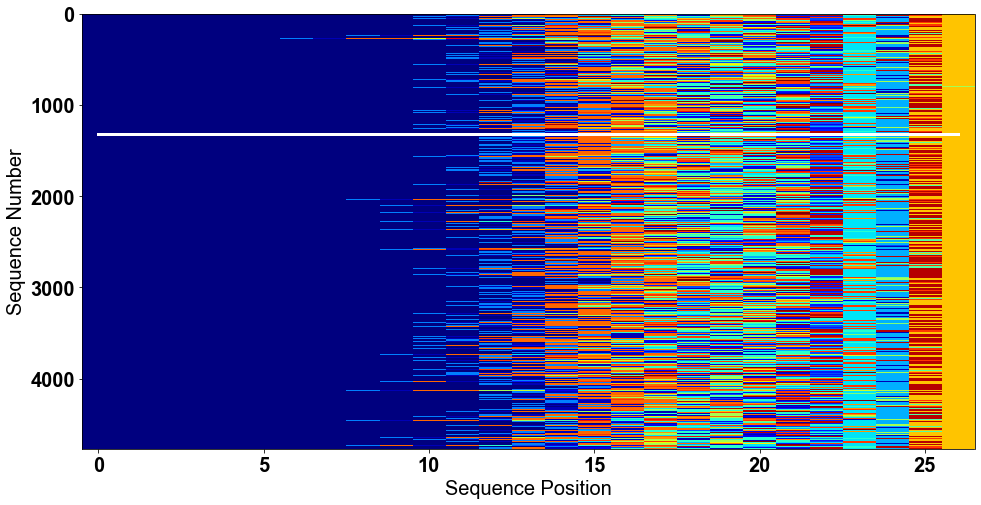

In [10]:
seq_MI1 = aims.gen_tcr_matrix(np.array(seq1),key = AA_num_key, giveSize = mat_size, alignment = 'right')
seq_MI2 = aims.gen_tcr_matrix(np.array(seq2),key = AA_num_key, giveSize = mat_size, alignment = 'right')
seq_MIp1 = pandas.DataFrame(np.transpose(seq_MI1),columns = seq1.columns)
seq_MIp2 = pandas.DataFrame(np.transpose(seq_MI2),columns = seq2.columns)
seq_MIf = pandas.concat([seq_MIp1,seq_MIp2],axis=1)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
ax[0,0].imshow(np.transpose(seq_MIf), interpolation='nearest', aspect='auto',cmap=cm.jet)
ax[0,0].set_ylabel('Sequence Number')

# Plot a single line delineating the distinct groups we are studying.
ax[0,0].plot(np.arange(len(seq_MIf)),np.ones(len(seq_MIf))*len(seq_MI1),'white',linewidth = 3)

if num_loop == 1:
    ax[0,0].set_xlabel('Sequence Position')
elif num_loop == 2:
    ax[0,0].set_xticks(xtick_loc)
    ax[0,0].set_xticklabels(['CDR3L','CDR3H'])
elif num_loop == 6:
    ax[0,0].set_xticks(xtick_loc)
    ax[0,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])
# Can also edit the saved figure name and format, if you want
#pl.savefig('matrix_fig.pdf',format='pdf')

In [ ]:
pca_props = aims.gen_clone_props(np.array(np.transpose(seq_MIf)))
pcaF = pandas.DataFrame(pca_props,columns = seq_MIf.columns)
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
x_axis = np.array([-0.2,0.9,2,3.1])
# Need to have some kind of color wheel to replace this...
#colors = ['purple','green','black','orange']
for i in np.arange(len(label)):
    index = [column for column in pcaF.columns if label[i] in column]
    plotThis = np.array(pcaF[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    ax[0,0].bar(x_axis+i*1/len(label), np.average(plotThis[1:5,:],axis = 1),
                yerr = np.std(plotThis[1:5,:],axis = 1),alpha = 0.5, width = 1/len(label))
ax[0,0].legend(label)
ax[0,0].set_xticks([0.2,1.3,2.4,3.5])
ax[0,0].set_xticklabels(['Charge','Hydrophobicity','Flexibility','Bulkiness'])
ax[0,0].set_xlabel('Biophysical Property')
ax[0,0].set_ylabel('Normalized Property Value')
#pl.savefig('property_fig.pdf',format='pdf')

Text(0, 0.5, 'Normalized Hydrophobicity')

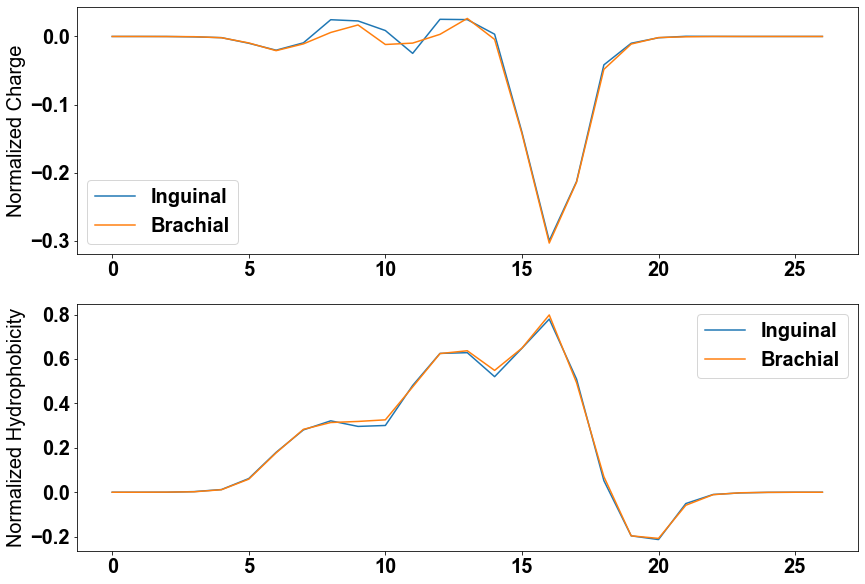

In [16]:
#pos_sens=aims.gen_dset_props(np.array(np.transpose(seq_MIf)),stdev=False)
fig, ax = pl.subplots(2, 1,squeeze=False,figsize=(14,10))
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
   
    pos_sens, dat_stdev =aims.gen_dset_props(np.array(np.transpose(subset)),stdev=True)
    
    for prop in np.arange(2):
        if prop == 0:
            x = 0; y = 0
        elif prop == 1:
            x = 1; y = 0
#        elif prop == 2:
#            x = 1; y = 0
#        elif prop == 3:
#            x = 1; y = 1
        plotThis = pos_sens[prop+2]
        error = dat_stdev[prop+2]
        # Specifically plot the first 5 properties here... Make sure that I 
        # have some way soon to actually select these...
        ax[x,y].plot(np.arange(len(plotThis)), plotThis)
        #ax[x,y].fill_between(np.arange(len(plotThis)),plotThis+error,plotThis-error,color='grey',alpha=0.2)
        
ax[0,0].legend(label)
ax[1,0].legend(label)

#ax[0,0].set_xticks(xtick_loc)
#ax[0,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])

#ax[1,0].set_xticks(xtick_loc)
#ax[1,0].set_xticklabels(['CDR1L','CDR2L','CDR3L','CDR1H','CDR2H','CDR3H'])

ax[0,0].set_ylabel('Normalized Charge')
ax[1,0].set_ylabel('Normalized Hydrophobicity')

#pl.savefig('pos_sens_fig.pdf',format='pdf')

/opt/anaconda3/envs/immunopep/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 85.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


0.62301148285202


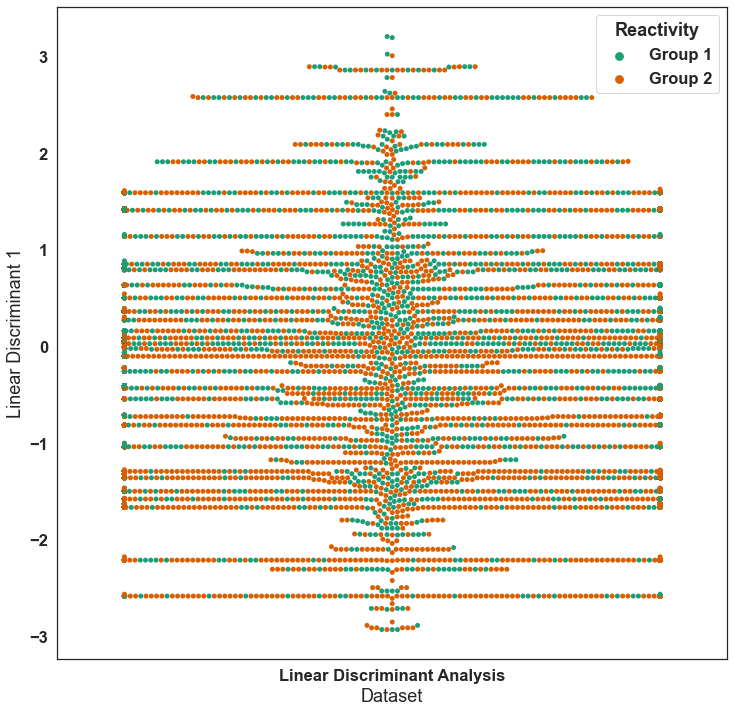

In [10]:
numVects = 10
# Here we also need to get a pre-defined matrix size...
import aims_classification as classy
pg1 = seq1.values
pg2 = seq2.values

num1 = np.shape(pg1)[1]
num2 = np.shape(pg2)[1]
#pg2 = seq2.values
x,y,MatrixSize = aims.gen_tcr_matrix(pg1,pre_mono=pg2,binary=True,return_Size=True,giveSize = mat_size)
acc_all,weights,cols,indices,mda_all,did_drop = classy.do_linear_split(pg1, pg2, giveSize = MatrixSize, matSize = numVects)
# Seaborn plots look nicer for these LDA figures
import seaborn as sns
fig = pl.figure(figsize = (12, 12))
dset = ["Linear Discriminant Analysis" for x in range(num1+num2)]
reacts = ["Group 1" for x in range(num1)] + ["Group 2" for x in range(num2)]

d1 = {'Dataset': dset, 'Linear Discriminant 1': mda_all.reshape(len(mda_all)),
    'Reactivity' : reacts}
df1 = pandas.DataFrame(data=d1)
sns.set(style="white", color_codes=True,font_scale=1.5)
sns.swarmplot(x="Dataset", y="Linear Discriminant 1", data=df1, hue = 'Reactivity', palette = "Dark2")
print(acc_all)
#pl.savefig('lda_fig.pdf',format='pdf')

In [33]:
indices_topProps = np.argsort(abs(weights))
compile_Props = np.vstack((cols[indices],weights))
final_pc1 = compile_Props[:,indices_topProps[0][-10:]]
print(final_pc1[0,0])
print(round(final_pc1[1,0]**2,4))

Hot22-17
0.0039


Text(0, 0.5, 'Shannon Entropy (Bits)')

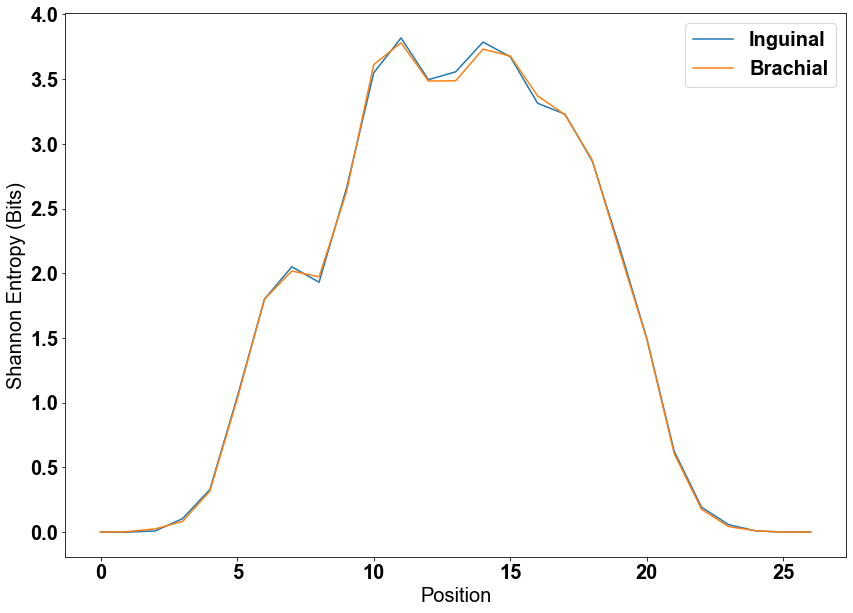

In [17]:
# There's no reason to not add the information theory stuff, even if it isn't in the app yet
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(14,10))
poses = len(seq_MIf)
frequencies = np.zeros((2,poses,21))
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
    entropy,AA_count=aims.calculate_shannon(np.transpose(subset))
    frequencies[i] = AA_count
    pl.plot(entropy)
    
pl.legend(label)
pl.xlabel('Position')
pl.ylabel('Shannon Entropy (Bits)')
#pl.savefig('entropy_fig.pdf',format='pdf')

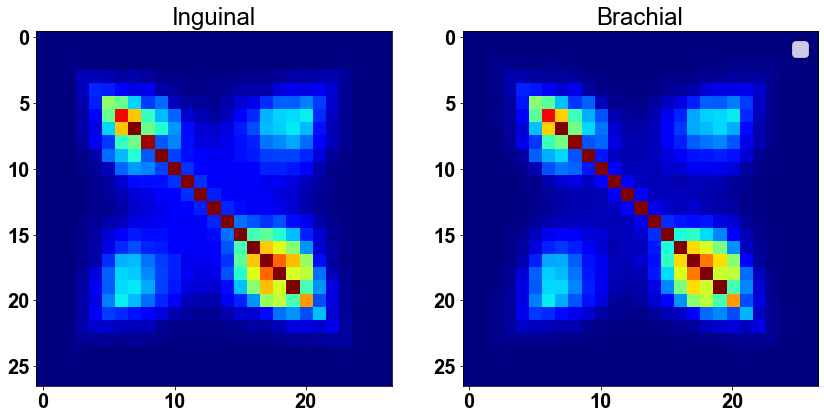

In [18]:
# And then the mutual information:
fig, ax = pl.subplots(1, 2,squeeze=False,figsize=(14,10))
for i in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[i] in column]
    subset = np.array(seq_MIf[index])
    MI,entropy_cond,counted=aims.calculate_MI(np.transpose(subset))
    ax[0,i].imshow(MI,vmin=0,vmax=2,cmap=cm.jet)
#pl.colorbar(x)
ax[0,0].set_title(label[0])
ax[0,1].set_title(label[1])
pl.legend(label)
#pl.savefig('MI_fig.pdf',format='pdf')

# I need to have something to get out the "word" probabilities of these datasets
From there, we then need to decide if we want to do our analyses on unique or expanded clones

In [28]:
# NOTE: Drop duplicates only works on rowise entries, not column-wise
print(np.shape(d2))
print(np.shape(d2.drop_duplicates()))

(3455,)
(3261,)


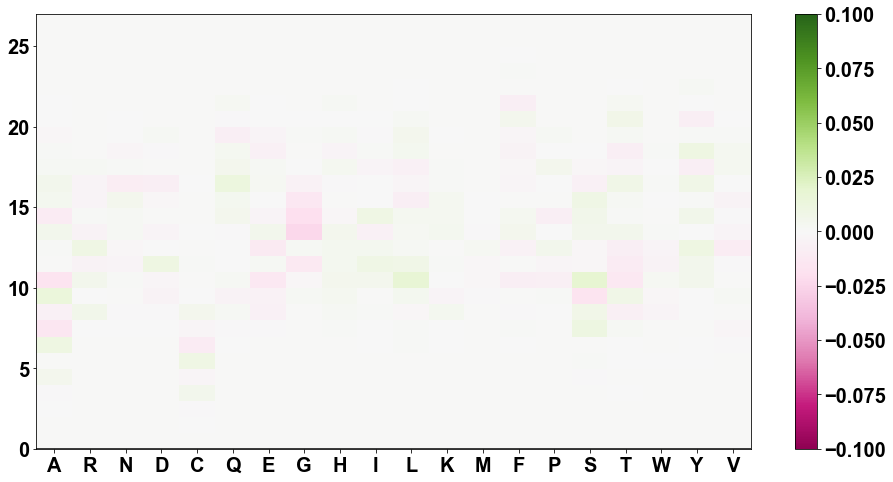

In [19]:
# Alright so the frequency data is actually calculated on the Shannon Entropy step
# Go back to that code to make sure we save it somehow, then just plot it here

fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
# We need to have the data in the binary groups though, since we're taking a difference.
# The 1: excludes "empty space" as a frequency
x=ax[0,0].pcolormesh(frequencies[0,:,1:]-frequencies[1,:,1:],vmin=-0.1,vmax=0.1,cmap=cm.PiYG)
AA_key=['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']
pl.colorbar(x)
xax=pl.setp(ax,xticks=np.arange(20)+0.5,xticklabels=AA_key)

place=0
if type(mat_size) == int:
    pl.plot(np.arange(21),place*np.ones(21),'black')
else:
    for i in mat_size:
        place += i
        pl.plot(np.arange(21),place*np.ones(21),'black')

#pl.savefig('FULLdata_AAprob.eps', format='eps')# dpi=1000)

Text(0.5, 0, 'Amino Acid')

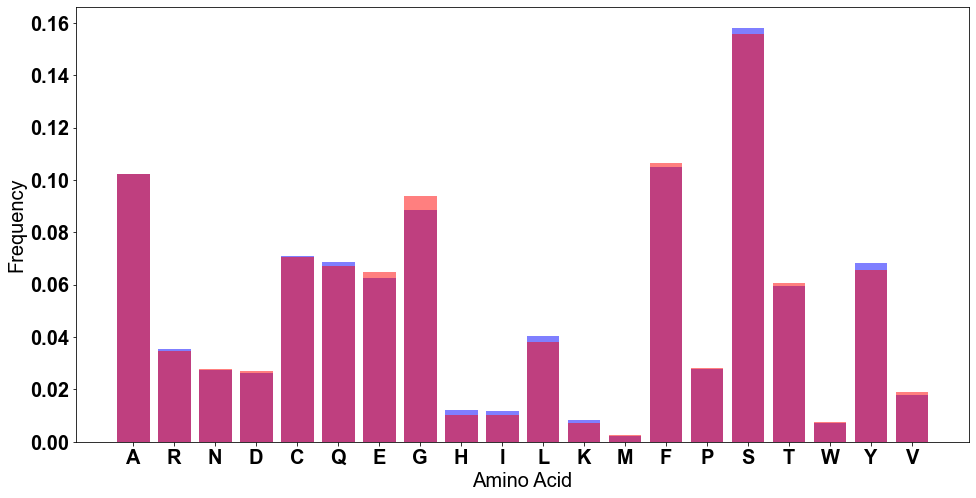

In [20]:
# Pull apart the shannon entropy script, because this is how we calculated AA probabilities
# Original script has position sensitivity, so we now DONT want that.
AA_freq_all = np.zeros((len(label),21))
digram_all = np.zeros((len(label),21,21))
a = 0; b = 0
for dset in np.arange(len(label)):
    index = [column for column in seq_MIf.columns if label[dset] in column]
    subset = np.transpose(np.array(seq_MIf[index]))
    clones,aas = np.shape(subset)
    AAs = np.arange(0,21)
    
    prob_poly_full=np.zeros((clones,21))
    prob_di_full = np.zeros((clones,21,21))
    for i in np.arange(clones):
        # we need to get back out how long our peptides are...
        space = 0
        digrams = 0
        for j in np.arange((aas)):
            # This is here so we can skip "space"
            if subset[i, j] == 0:
                space += 1
                continue
            for k in AAs:
                if subset[i, j]==k:
                    if subset[i,j] == 0:
                        continue
                    # Very simple count of the number of times we see an AA
                    prob_poly_full[i, k]=prob_poly_full[i, k]+1
                    # Find our digram frequencies
                    if j == aas-1:
                        # obviously can't get the digram of the last entry
                        # I guess technically you can... but for now, don't
                        continue
                    for di_pair in AAs:
                        # need to do this in order to ignore the spaces
                        q = 0
                        if subset[i, j+1] != 0:
                            # secAA is SECOND AMINO ACID
                            secAA = subset[i, j+1]
                        else:
                            while subset[i,j+q] == 0:
                                if j+q > aas:
                                    break
                                q += 1
                            secAA = subset[i, j+q]

                        if secAA == di_pair:
                            prob_di_full[i, k, di_pair] = prob_di_full[i, k, di_pair] + 1
                            digrams += 1
                            break
                    # break out of location (i, j) so we can save a tiny bit of time
                    break
        # renormalize this clone by the length of the peptide
        prob_di_full[i] = prob_di_full[i]/digrams
        if aas-space == 0:
            print('shit')
            print(space)
        prob_poly_full[i] = prob_poly_full[i]/(aas-space)
    # Since we are no longer looking at position sensitive probabilities,
    # we need to also divide by the number of positions (also 14)
    AA_freq_all[dset]=np.sum(prob_poly_full,axis=0)/clones
    digram_all[dset] = np.sum(prob_di_full,axis=0)/clones

fig, ax = pl.subplots(int(len(label)/2), 1,squeeze=False,figsize=(16,8))
for i in np.arange(0,len(label),2):
    ax[int(i/2),0].bar(np.arange(len(AA_freq_all[i,1:])),AA_freq_all[i,1:], color='blue',alpha=0.5)
    ax[int(i/2),0].bar(np.arange(len(AA_freq_all[i+1,1:])),AA_freq_all[i+1,1:],color='red',alpha=0.5)
xax=pl.setp(ax,xticks=np.arange(20),xticklabels=AA_key)
#pl.legend(label)
pl.ylabel('Frequency')
pl.xlabel('Amino Acid')

#shannon_poly=np.zeros(len(poly_count))
#for i in np.arange(len(poly_count)):
 #   for j in np.arange(len(poly_count[0])):
#        if poly_count[i,j]==0:
#            continue
#        shannon_poly[i]=shannon_poly[i]+(-poly_count[i,j]*math.log(poly_count[i,j],2))
#return(shannon_poly,poly_count)

# For some reason, there is more Q and E in some TEM sets
Although checking a couple, this trend doesn't seem to persist

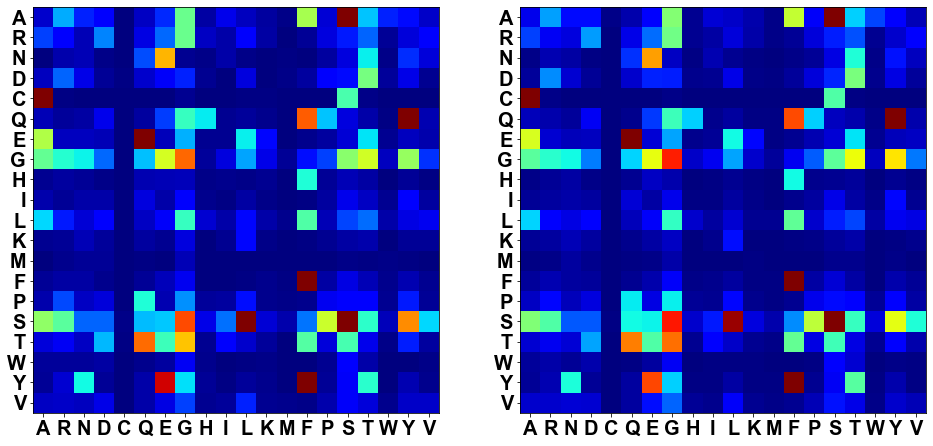

In [21]:
fig, ax = pl.subplots(int(len(label)/2), 2,squeeze=False,figsize=(16,8))
a = 0; b = 0
for i in np.arange(len(label)):
    ax[a,b].imshow(digram_all[i,1:,1:],vmin = 0, vmax = 0.015,  cmap = cm.jet)
    if b == 1:
        a += 1
        b = 0
    else:
        b += 1

xax=pl.setp(ax[a-1,0],xticks=np.arange(20),xticklabels=AA_key)
yax=pl.setp(ax[a-1,0],yticks=np.arange(20),yticklabels=AA_key)
xax=pl.setp(ax[a-1,1],xticks=np.arange(20),xticklabels=AA_key)
yax=pl.setp(ax[a-1,1],yticks=np.arange(20),yticklabels=AA_key)

# Same as above, for some reason the digram EQ is more common in TEM

Text(0.5, 0, 'Second Amino Acid')

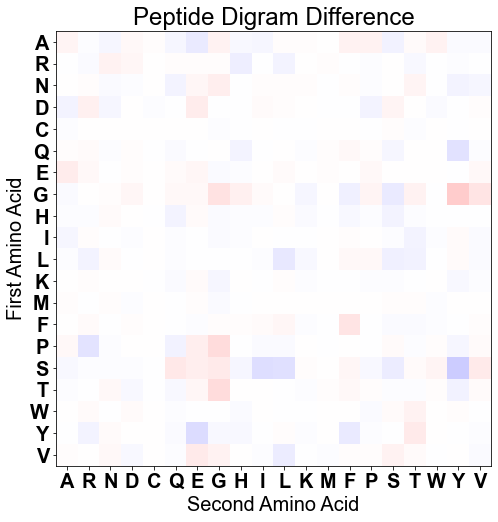

In [22]:
fig, ax = pl.subplots(1, 1,squeeze=False,figsize=(16,8))
pl.title('Peptide Digram Difference')
pl.imshow(digram_all[1,1:,1:]-digram_all[0,1:,1:], vmin = -0.01, vmax = 0.01, cmap = cm.bwr)
xax=pl.setp(ax,xticks=np.arange(20),xticklabels=AA_key)
yax=pl.setp(ax,yticks=np.arange(20),yticklabels=AA_key)
ax[0,0].set_ylabel('First Amino Acid')
ax[0,0].set_xlabel('Second Amino Acid')

[0.27738518 0.13977726 0.11819781]


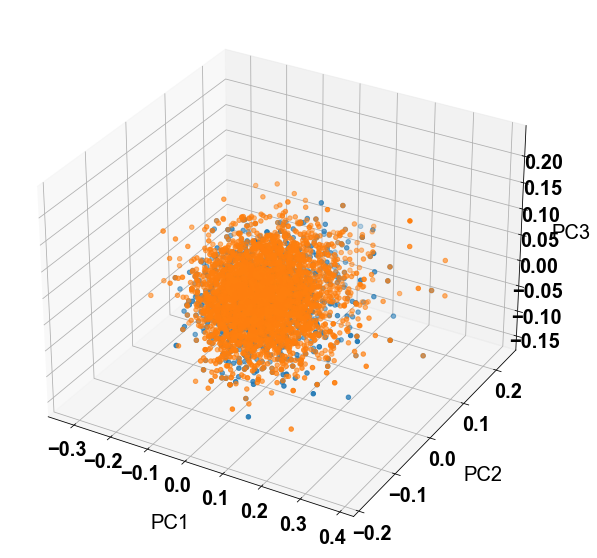

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, svd_solver='full')
final=pca.fit_transform(np.transpose(pca_props))
#seq_PCA = aims.gen_tcr_matrix(np.array(seq_final),key = AA_num_key, giveSize = mat_size)
#final = pca.fit_transform(seq_PCA)
print(pca.explained_variance_ratio_)

from mpl_toolkits import mplot3d
fig3d = pl.figure(figsize = (10, 10))
ax3d = fig3d.add_subplot(111, projection='3d')

# Alright plot this in an intelligent way
transform_pca = pandas.DataFrame(np.transpose(final),columns = seq_MIf.columns)
for i in np.arange(len(label)):
    index = [column for column in transform_pca.columns if label[i] in column]
    plotThis = np.array(transform_pca[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    ax3d.scatter(plotThis[0], plotThis[1], plotThis[2])

ax3d.set_xlabel('PC1',labelpad=20)
ax3d.set_ylabel('PC2',labelpad=20)
ax3d.set_zlabel('PC3',labelpad=10)
#pl.savefig('PCA_parsedata_3D.pdf',DPI=500,format='pdf')
pl.show()

Text(0, 0.5, 'PC2')

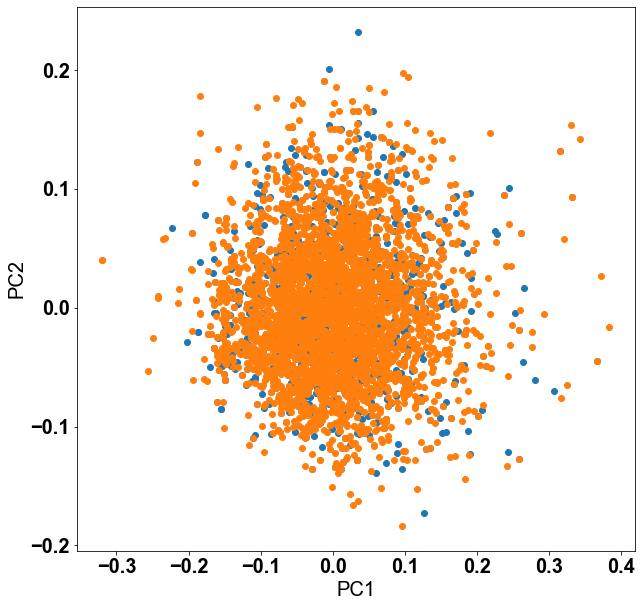

In [30]:
fig = pl.figure(figsize = (10, 10))
for i in np.arange(len(label)):
    #if i == 2:
    #    continue
    index = [column for column in transform_pca.columns if label[i] in column]
    plotThis = np.array(transform_pca[index])
    # Specifically plot the first 5 properties here... Make sure that I 
    # have some way soon to actually select these...
    pl.scatter(plotThis[0], plotThis[1])
    
pl.xlabel('PC1')
pl.ylabel('PC2')
#pl.savefig('PCA_2Dparse.pdf',DPI=500,format='pdf')

In [47]:
# Maybe we should try doing UMAP? Idk at least test it out.
import umap
# I guess I should Scale the data?
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP(n_components=2, n_neighbors = 500)
fulldata = pandas.DataFrame(np.transpose(pca_props))
scaleData = StandardScaler().fit_transform(fulldata)

In [48]:
# Thankfully, not that slow
embedding = reducer.fit_transform(scaleData)
embedding.shape
# NOTES ON REPRODUCIBILITY:
# "multi-threaded UMAP results cannot be explicitly reproduced" - so don't multi-thread
# setting a random seed is like signing a waiver 
#“I am aware that this is a stochastic algorithm and I have done sufficient tests to confirm that my main conclusions are not affected by this randomness"
# So if you agree to "sign that waiver", then set a random seed using "random_state = 42" or whatever number you want

(4770, 2)

Text(0.5, 1.0, 'UMAP')

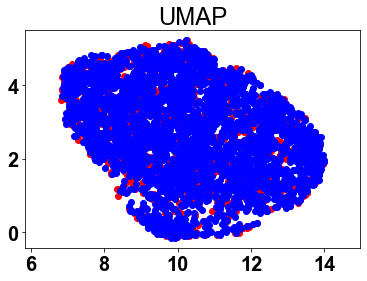

In [49]:
pl.scatter(
    embedding[:1315, 0],
    embedding[:1315, 1],
    color='red')
pl.scatter(
    embedding[1315:, 0],
    embedding[1315:, 1],
    color='blue')
pl.gca().set_aspect('equal', 'datalim')
pl.title('UMAP', fontsize=24)

# Systematically Move and Rename Files in this Dataset
For now, only rename based upon HLA haplotype and organ source



In [ ]:
# Alright need to play around with the metadata a little bit:
# I need to try to make an interactive script that let's me search through all of 
# the "tissue source" options. All of the "HLA MHC class" options, etc.
sub1 = 'NAIVE/'
for i in os.listdir(tissue_dir+sub1):
    A = False; B = False; C = False
    if i[-3:] == 'csv':
        d1 = pandas.read_csv(tissue_dir + sub1 + i ,sep=',')
        # Minus 5 here because we have 5 entries
        for j in np.arange(np.shape(d1)[1]-5):
            entry = str(j)
            start = d1[entry][0].find('-')
            #Let's also try to find the organ
            if d1[entry].str.contains('Tissue Source')[0]:
                if d1[entry].str.contains('T cell')[0]:
                    continue
                elif d1[entry].str.contains('gDNA')[0]:
                    continue
                s2 = d1[entry][0].find(':')
                s3 = d1[entry][0][s2+1:].find('Tissue')
                if s3 == -1:
                    organ = d1[entry][0][s2+1:].replace(' ','_')
            # HLA are always going to have a "-", so continue if not
            if start == -1:
                continue
            if d1[entry].str.contains('HLA-A')[0]:
                if A:
                    hlaA = hlaA +  [d1[entry][0][start+1:].replace('*','')]
                else:
                    hlaA = [d1[entry][0][start+1:].replace('*','')]
                A = True
            # Need to specially exclude HLA-Bw4 and Bw6
            elif d1[entry].str.contains('HLA-Bw')[0]:
                continue
            elif d1[entry].str.contains('HLA-B')[0]:
                if B:
                    hlaB = hlaB + [d1[entry][0][start+1:].replace('*','')]
                else:
                    hlaB = [d1[entry][0][start+1:].replace('*','')]
                B = True
            if d1[entry].str.contains('HLA-C')[0]:
                if C:
                    hlaC = hlaC + [d1[entry][0][start+1:].replace('*','')]
                else:
                    hlaC = [d1[entry][0][start+1:].replace('*','')]
                    
        # NOTE, LEAVING OUT HLA-C FOR NOW... Maybe include down the line
        if os.path.isdir(tissue_dir + sub1 + '_'.join(hlaA + hlaB)):
            shutil.copy(tissue_dir + sub1 + i , tissue_dir+sub1 + '_'.join(hlaA + hlaB)+'/'+organ+'_'+i)
        else:
            os.mkdir(tissue_dir + sub1 + '_'.join(hlaA + hlaB))
            shutil.copy(tissue_dir + sub1 + i, tissue_dir+sub1 + '_'.join(hlaA + hlaB)+'/'+organ+'_'+i)